In [76]:
# Gib deine AniList Usernamen ein:
username = 'Youmukami'
titleLanguage = 'romaji' #'english' or 'romaji' (english may not work, if an anime has no English title)

In [77]:
import datetime
import json
import time
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy


import requests


def getInfos(username, page, startedAt_greater):
    query = '''
query ($page: Int, $perPage: Int, $username: String, $startedAt_greater: FuzzyDateInt) {
  Page (page: $page, perPage: $perPage) {
    pageInfo {
        currentPage
        hasNextPage
        lastPage
    }
    mediaList(userName: $username, startedAt_greater: $startedAt_greater) {
      score
      status
      progress
      startedAt {
        year
        month
        day
      }
        media {
        genres
        format
          title {
            english
            romaji
        }
      }
    }
  }
}
        '''
    variables = {
        'type': 'ANIME',
        'username': username,
        'perPage': 50,
        'page': page,
        'startedAt_greater': startedAt_greater
    }

    headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json'
    }

    url = 'https://graphql.anilist.co'

    response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)

    if response.status_code == 404:
        print(variables)
        return []

    if response.status_code == 429:
        print("Rate Limit hit: Waiting 60 seconds")
        time.sleep(60)
        return getInfos(username, page + 1, startedAt_greater)

    return json.loads(response.text)


entries = list()

hasNext = True
page = 1

while hasNext:
    res = getInfos(username, page, 20210000)
    if not res["data"]["Page"]["pageInfo"]["hasNextPage"]:
        hasNext = False
    tmp = [v for v in res["data"]["Page"]["mediaList"]]
    for entry in tmp:
        entry["title"] = entry["media"]["title"][titleLanguage]
        entry["startedAt"] = datetime.date(entry["startedAt"]["year"],entry["startedAt"]["month"],entry["startedAt"]["day"])
        entry["genres"] = entry["media"]["genres"]
        entry["format"] = entry["media"]["format"]
    entries.append(tmp)
    page = page + 1

res = [item for sublist in entries for item in sublist]

data = pd.DataFrame(res, columns=['score', 'title', 'format', 'genres', 'progress', 'startedAt', 'status'])

Anzahl gesehener Titel:

ALLE: 437 Anzahl Episoden: 1441
Abgeschlossen: 193 Anzahl Episoden: 1073
Abgebrochen: 141 Anzahl Episoden: 145
Geplant: 91 Anzahl Episoden: 75
Pausiert: 4 Anzahl Episoden: 6


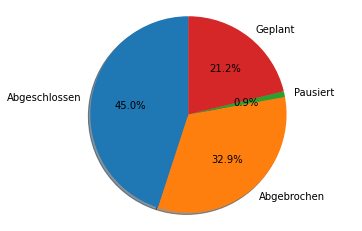

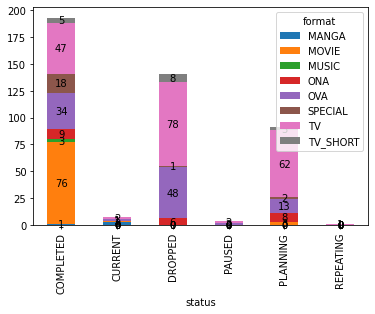

In [78]:
completed = data[data["status"] == 'COMPLETED']
dropped = data[data["status"] == 'DROPPED']
planned = data[data["status"] == 'PLANNING']
paused = data[data["status"] == 'PAUSED']
print("ALLE: " + str(len(data.index)) + " Anzahl Episoden: " + str(data['progress'].sum()))
print("Abgeschlossen: " + str(len(completed)) + " Anzahl Episoden: " + str(completed['progress'].sum()))
print("Abgebrochen: " + str(len(dropped)) + " Anzahl Episoden: " + str(dropped['progress'].sum()))
print("Geplant: " + str(len(planned)) + " Anzahl Episoden: " + str(planned['progress'].sum()))
print("Pausiert: " + str(len(paused)) + " Anzahl Episoden: " + str(paused['progress'].sum()))

labels = 'Abgeschlossen', 'Abgebrochen', 'Pausiert', 'Geplant'
sizes = numpy.array([len(completed), len(dropped), len(paused), len(planned)])

def absolute_value(val):
    a  = numpy.round(val/100.*sizes.sum(), 0)
    return int(a)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

ax = data.groupby(['status', 'format']).size().unstack().plot(kind='bar', stacked=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')


Nach Punktzahl sortiert:

Durschnitt:5.097236180904522


,index,score,title,format,genres,progress,startedAt,status
0,2,10.0,Higurashi no Naku Koro ni Kai,TV,"[Horror, Mystery, Psychological, Supernatural,...",19,2021-10-31,REPEATING
1,1,10.0,Higurashi no Naku Koro ni,TV,"[Horror, Mystery, Psychological, Supernatural,...",26,2021-09-13,COMPLETED
2,9,10.0,Flip Flappers,TV,"[Action, Adventure, Comedy, Fantasy, Mahou Sho...",13,2021-09-11,COMPLETED
3,295,10.0,Fate/stay night [Heaven's Feel] III. spring song,MOVIE,"[Action, Drama, Fantasy, Psychological, Supern...",1,2021-09-04,COMPLETED
4,24,9.6,Tenki no Ko,MOVIE,"[Drama, Romance, Slice of Life, Supernatural]",1,2021-01-01,COMPLETED
5,21,9.5,Seishun Buta Yarou wa Yumemiru Shoujo no Yume ...,MOVIE,"[Drama, Psychological, Romance, Supernatural]",1,2021-11-28,COMPLETED
6,16,9.5,Seishun Buta Yarou wa Bunny Girl Senpai no Yum...,TV,"[Comedy, Drama, Mystery, Psychological, Romanc...",13,2021-11-07,COMPLETED
7,248,9.5,Fate/stay night [Heaven's Feel] II. lost butte...,MOVIE,"[Action, Fantasy, Psychological, Supernatural]",1,2021-09-04,COMPLETED
8,6,9.5,Steins;Gate 0,TV,"[Drama, Sci-Fi, Thriller]",23,2021-01-17,COMPLETED
9,17,9.3,Kaguya-sama wa Kokurasetai: Tensaitachi no Ren...,TV,"[Comedy, Psychological, Romance, Slice of Life]",12,2021-12-19,COMPLETED


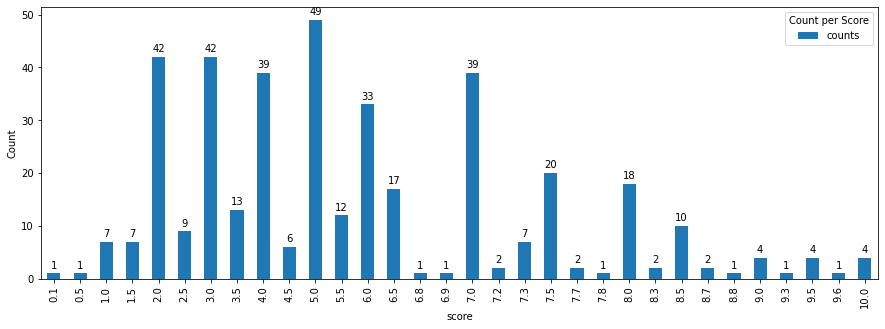

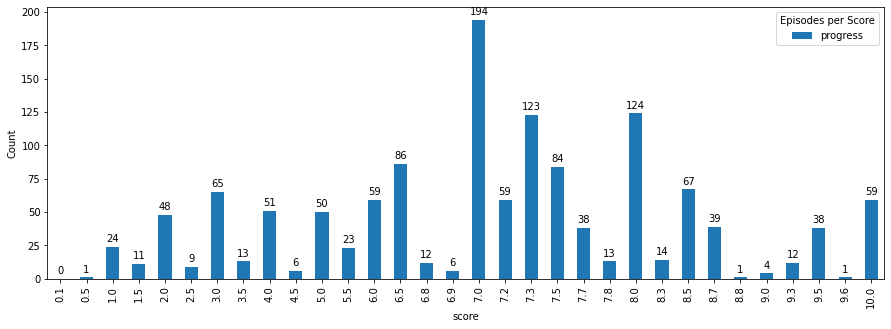

In [79]:
figsize = [15,5]
fontsize = 10
maximum_rows = None # Gebe eine Zahl für die Anzahl an Zeilen, die ausgegeben werden sollen. 'None' bedeutet ALLE ausgeben

pd.set_option('display.max_rows', maximum_rows, 'display.max_columns', None)
filtered = data[data['score'] != 0]

print("Durschnitt:" + str(filtered['score'].mean()))

display(filtered.sort_values(by=['score', 'startedAt'], ascending=False).reset_index().head(maximum_rows))

ax = filtered.groupby(['score']).size().reset_index(name='counts').plot.bar(figsize=figsize, x='score', fontsize=fontsize, ylabel="Count", label='Score')
ax.legend(fontsize=fontsize, title='Count per Score', title_fontsize=fontsize)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), 'd'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=fontsize, xytext=(0, 8),
                   textcoords='offset points')
    
ax = filtered.groupby(['score']).sum().reset_index().plot.bar(figsize=figsize, x='score', fontsize=fontsize, ylabel="Count", label='Score')
ax.legend(fontsize=fontsize, title='Episodes per Score', title_fontsize=fontsize)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), 'd'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=fontsize, xytext=(0, 8),
                   textcoords='offset points')


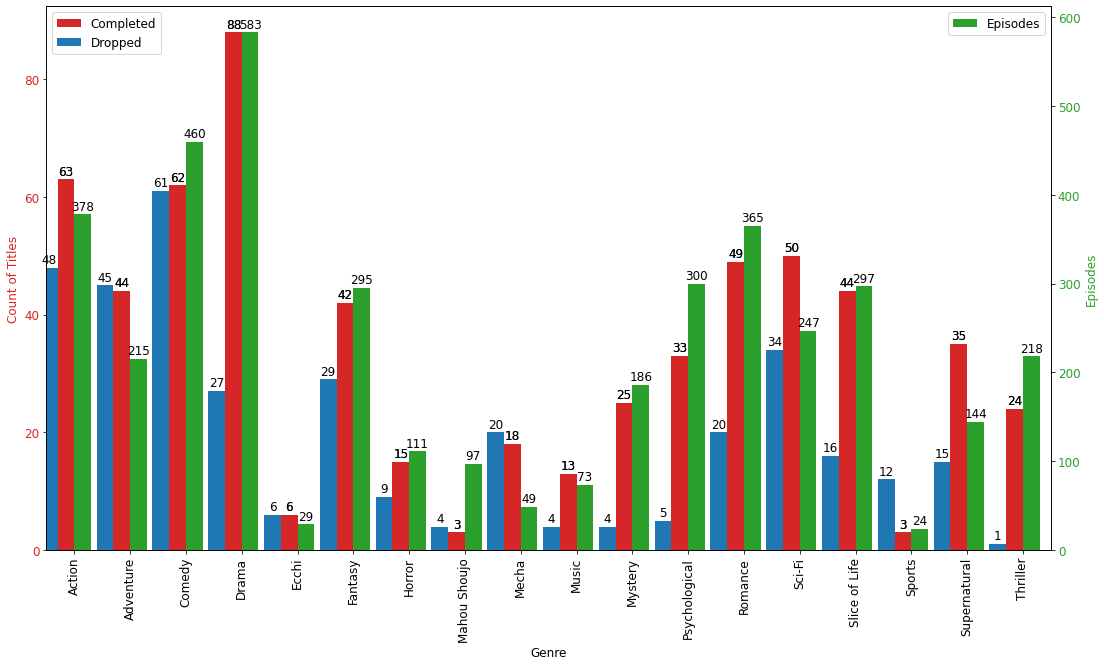

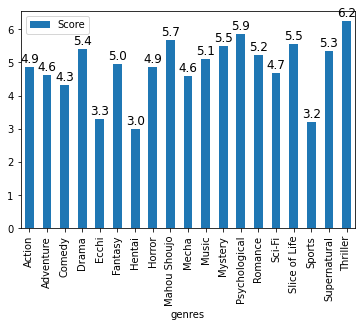

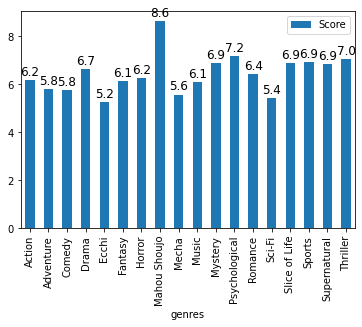

In [81]:
figsize = [18,10]
fontsize = 12
width = 0.3

completed = data[data["status"] == "COMPLETED"]
color = 'tab:red'
ax1 = completed.genres.explode('genres').value_counts().sort_index().plot.bar(figsize=figsize, width=width, color=color, fontsize=fontsize, position=1, label='Completed')
ax1.set_xlabel('Genre', fontsize=fontsize) 
ax1.set_ylabel('Count of Titles', color = color, fontsize=fontsize) 
ax1.tick_params(axis ='y', labelcolor = color) 

for bar in ax1.patches:
    ax1.annotate(format(bar.get_height(), 'd'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=fontsize, xytext=(0, 8),
                   textcoords='offset points')

ax2 = ax1.twinx()
color = 'tab:green'
ax = completed.explode('genres').groupby(['genres']).sum().plot.bar(legend=False, ax=ax2, width=width, color=color, position=0, figsize=figsize, y='progress', fontsize=fontsize, label='Episodes')
ax.set_ylabel('Episodes', color = color, fontsize=fontsize)
ax.tick_params(axis ='y', labelcolor = color)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), 'd'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=fontsize, xytext=(0, 8),
                   textcoords='offset points')
    
#dropped = data[data["status"] == "DROPPED"]
#ax = dropped.genres.explode('genres').value_counts().sort_index().drop('Hentai', errors='ignore').plot.bar(ax=ax1, label='Dropped', position=2, width=width)
#for bar in ax.patches:
#    ax.annotate(format(bar.get_height(), 'd'),
#                   (bar.get_x() + bar.get_width() / 2,
#                    bar.get_height()), ha='center', va='center',
#                    size=fontsize, xytext=(0, 8),
#                    textcoords='offset points')
    
plt.xlim((-0.5, 18-0.5));

ax1.legend(loc="upper left", fontsize=fontsize, title_fontsize=fontsize)
ax2.legend(fontsize=fontsize, title_fontsize=fontsize)

    

ax = data.explode('genres').groupby(['genres']).mean().plot.bar(y='score', label='Score')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '0.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=fontsize, xytext=(0, 8),
                   textcoords='offset points')
    
ax = completed.explode('genres').groupby(['genres']).mean().plot.bar(y='score', label='Score')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '0.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=fontsize, xytext=(0, 8),
                   textcoords='offset points')
    

